## Download Dependencies

In [1]:
%%capture

!pip install gdown
!gdown --no-cookies 1PP3FTLUAWbe-3X1xdA4c5CqZxCZqYvp-

In [2]:
import pickle

with open('aerial_sampling_points.pkl', 'rb') as f:
    aerial_sampling_points = pickle.load(f)
    
with open('/kaggle/input/dark-trajectories-0-39/dark_trajectories.pkl', 'rb') as f:
    dark_trajectories_paths = pickle.load(f)
    dark_trajectories_names = [path[-17:] for path in dark_trajectories_paths]

!rm /kaggle/working/aerial_sampling_points.pkl

### Load Google Maps API secrets

In [3]:
from kaggle_secrets import UserSecretsClient


user_secrets = UserSecretsClient()
API_KEY = user_secrets.get_secret("API_KEY")
SIGNATURE = user_secrets.get_secret("signature")

In [4]:
import io
import subprocess
import hashlib
import hmac
import base64
import urllib.parse as urlparse
import urllib3
from itertools import chain
from functools import lru_cache
from os import listdir, mkdir
from glob import glob

import PIL
import requests
from requests.adapters import HTTPAdapter
import cv2
import numpy as np
from requests.packages.urllib3.util.retry import Retry


input_path = '/kaggle/input'
output_path = '/kaggle/working/aerials'

retry_strategy = Retry(total=3)
adapter = HTTPAdapter(max_retries=retry_strategy)
http = requests.Session()
http.mount('https://', adapter)
http.mount('http://', adapter)

def get_trajectories_of_downloaded_parts():
    trajectories_names_ground = set(path[-17:] for path in glob(f'{input_path}/frame-extraction-*/frames/*'))
    bright_trajectories_ground = set(t for t in trajectories_names_ground if t not in dark_trajectories_names)
    trajectories_names_aerial = set(trajectory for trajectory in aerial_sampling_points.keys())
    trajecotries_names = bright_trajectories_ground & trajectories_names_aerial
    return sorted(list(trajecotries_names))


def sign_url(input_url=None, secret=None):
    """ Sign a request URL with a URL signing secret.
      Usage:
      from urlsigner import sign_url
      signed_url = sign_url(input_url=my_url, secret=SECRET)
      Args:
      input_url - The URL to sign
      secret    - Your URL signing secret
      Returns:
      The signed request URL
  """

    if not input_url or not secret:
        raise Exception("Both input_url and secret are required")

    url = urlparse.urlparse(input_url)

    # We only need to sign the path+query part of the string
    url_to_sign = url.path + "?" + url.query

    # Decode the private key into its binary format
    # We need to decode the URL-encoded private key
    decoded_key = base64.urlsafe_b64decode(secret)

    # Create a signature using the private key and the URL-encoded
    # string using HMAC SHA1. This signature will be binary.
    signature = hmac.new(decoded_key, str.encode(url_to_sign), hashlib.sha1)

    # Encode the binary signature into base64 for use within a URL
    encoded_signature = base64.urlsafe_b64encode(signature.digest())

    original_url = url.scheme + "://" + url.netloc + url.path + "?" + url.query

    # Return signed URL
    return original_url + "&signature=" + encoded_signature.decode()


def save_aerial_tile(point, save_path):
    base_url = "https://maps.googleapis.com/maps/api/staticmap"
    zoom   = 20
    scale  = 1
    size   = "800x800"
    center = f"{point[0]},{point[1]}"

    img_url = sign_url(
                f"{base_url}?key={API_KEY}" \
                f"&zoom={zoom}&scale={scale}&center={center}" \
                f"&size={size}&maptype=satellite&format=png" \
                f"&visual_refresh=true", SIGNATURE)

    try:
        img_bytes = http.get(img_url).content
    except urllib3.exceptions.MaxRetryError:
        print(point, save_path)
        return
    img_array = np.frombuffer(img_bytes, dtype=np.uint8)
    img_cv = cv2.imdecode(img_array, flags=cv2.IMREAD_UNCHANGED)
    img_resized = cv2.resize(img_cv, (400, 400), interpolation=cv2.INTER_AREA)
    cv2.imwrite(save_path, img_resized)
        
def get_trajectory_tiles(trajectory_name):
    save_path = f'{output_path}/{trajectory_name}'
    # make the trajectory directory
    mkdir(save_path)
    
    # Download aerial tile
    for idx, point in enumerate(aerial_sampling_points[trajectory_name]):
        save_aerial_tile(point, f'{save_path}/{idx:03d}.png')

# Prepare the aerial dataset

## Reset the output directory

In [5]:
!rm -rf $output_path && mkdir $output_path

## Calculating the number of API requests

In [6]:
trajectories_names = get_trajectories_of_downloaded_parts()

## Download the tiles

In [7]:
from multiprocessing.pool import ThreadPool


pool = ThreadPool(processes=100)
_ = pool.map(get_trajectory_tiles, trajectories_names[5000:10000])

# Visualization

In [8]:
from random import choice
from os import listdir

from IPython.display import Image, FileLink


def make_gif_from_frames(frames_path, output_path, *,loop=-1, fps=10):
    subprocess.check_call(['ffmpeg',
                           '-y',
                           '-hide_banner',
                           '-loglevel',
                           'error',
                           '-f',
                           'image2',
                           '-framerate',
                           str(fps),
                           '-pattern_type',
                           'glob',
                           '-i',
                           f"{frames_path}/*.png",
                           '-loop',
                           str(loop),
                           output_path
                        ])
    return Image(open(output_path, 'rb').read())    

def get_random_processed_video_name():
    return choice(listdir(output_path))

In [9]:
name = get_random_processed_video_name()

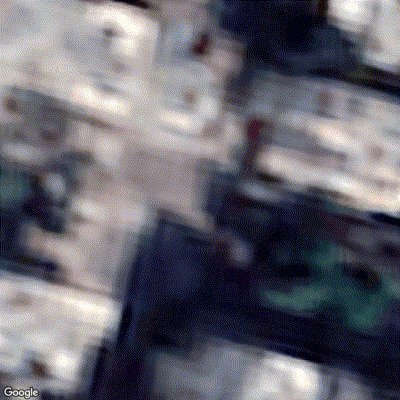

In [10]:
make_gif_from_frames(f'{output_path}/{name}', 'output.gif', fps=2) 

In [11]:
FileLink(f'output.gif')

/kaggle/working/output.gif